https://towardsdatascience.com/building-our-first-neural-network-in-keras-bdc8abbc17f5

### 0. Librerías

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
import itertools

from sklearn.model_selection import train_test_split

print(tf.__version__)

2.8.0


### 1. Carga del dataset


In [2]:
# Definición de variables globales
seed = 0

In [3]:
# Creamos una columna de etiqueta binaria
def secuestro(x):
    if x== 'white':
        valor = 0
    else:
        valor = 1
    return valor


In [4]:
# Cargamos la base de datos de entrenamiento
url = 'https://datos.uemc.es/owncloud/s/tekZoz67bNuD3X4/download?path=%2F&files=DATASET14.csv'
df = pd.read_csv(url, sep=',')

# Cargamos la base de datos de prueba
url_test = 'https://datos.uemc.es/owncloud/s/tekZoz67bNuD3X4/download?path=%2F&files=VALIDATION_WITHOUT_LABELS.csv'
df_test = pd.read_csv(url_test, sep=',')

# Creamos una columna de etiqueta binaria en los datos de entrenamiento
df['clase']=df['label'].apply(secuestro)

# Eliminamos las columnas label y las que no son validas segun el EDA (address, length y weight)
df = df.drop(['address', 'label', 'length','weight'], axis=1)
df_test = df_test.drop(['address', 'length','weight'], axis=1)

# Comprobamos que la carga de datos se ha llevado a cabo correctamente
print('Dataset de entrenamiento:\n', df.head())
print('Dataset sobre el que predecir:\n', df_test.head())

# Nombre y tipo de las columnas del entrenamiento
print('Columnas del dataset:\n{}\n'.format(df.dtypes))

# Cantidad de datos de cada clase
print('Datos de cada clase:\n{}\n'.format(df['clase'].value_counts()))

Dataset de entrenamiento:
    year  day  count  looped  neighbors     income  clase
0  2017   11      1       0          2  100050000      1
1  2016  132      1       0          1  100000000      1
2  2016  246      1       0          2  200000000      1
3  2016  238    456       0          1  200000000      1
4  2016   96   2821       0          1   50000000      1
Dataset sobre el que predecir:
    year  day  count  looped  neighbors     income
0  2016  298   4220       0          2   80000000
1  2016   56      4       0          1  500000000
2  2016   52   8120       0          1   50057953
3  2014   81      1       0          2  300000000
4  2016  336      1       0          2  100000000
Columnas del dataset:
year         int64
day          int64
count        int64
looped       int64
neighbors    int64
income       int64
clase        int64
dtype: object

Datos de cada clase:
0    2328979
1      33545
Name: clase, dtype: int64



### 2. Análisis de las características

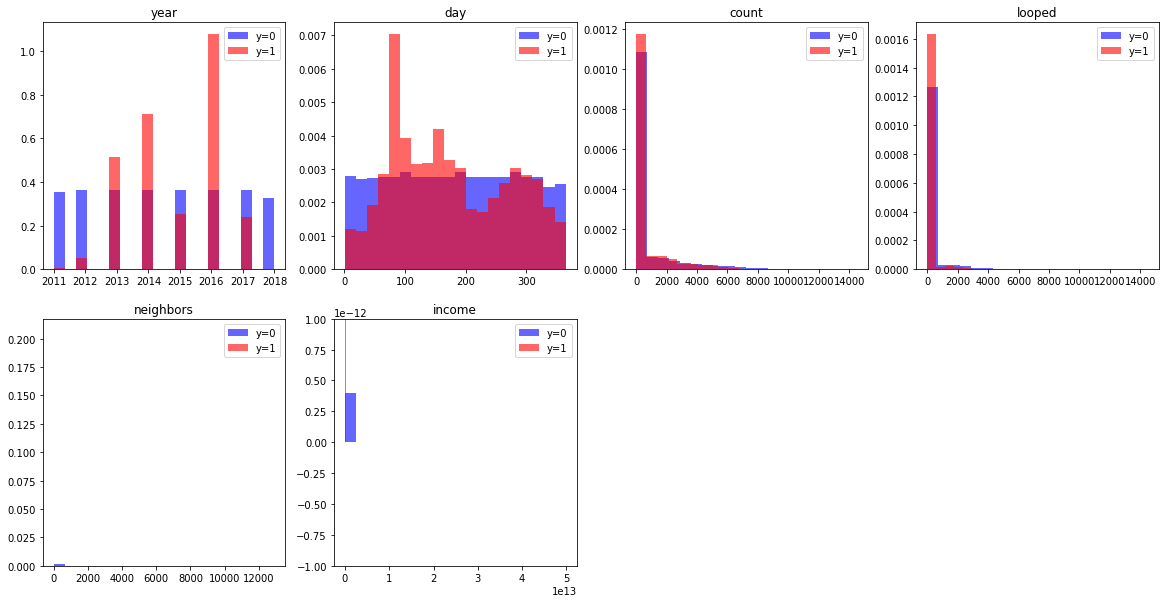

In [5]:
# Histograma de cada variable separado por clases
plt.figure(figsize=(20,10))

idx_0 =  df['clase'] == 0
idx_1 =  df['clase'] == 1

for i, feature in enumerate(df.columns.drop(['clase'])):
    plt.subplot(2, 4, i+1)   
    plt.hist(df.loc[idx_0,feature],density=1, bins=20, facecolor=(0,0,1,0.6), label='y=0')
    plt.hist(df.loc[idx_1,feature],density=1, bins=20, facecolor=(1,0,0,0.6), label='y=1')
    plt.legend()
    plt.title(feature)
plt.show()

In [6]:
df.head()

,year,day,count,looped,neighbors,income,clase
0,2017,11,1,0,2,100050000,1
1,2016,132,1,0,1,100000000,1
2,2016,246,1,0,2,200000000,1
3,2016,238,456,0,1,200000000,1
4,2016,96,2821,0,1,50000000,1


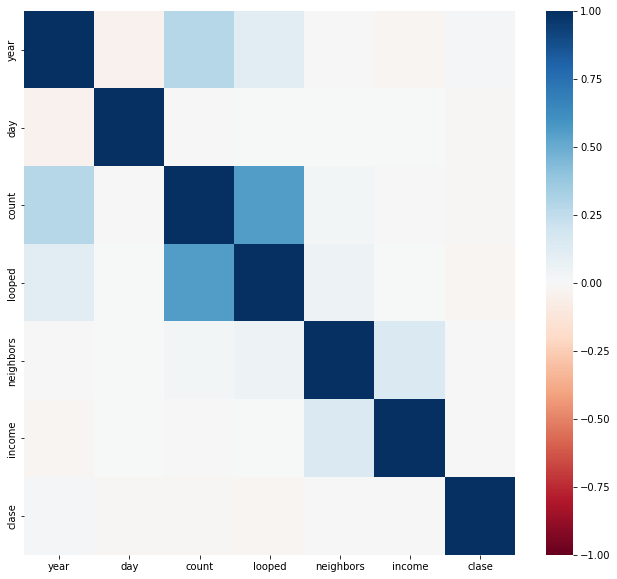

In [7]:
# Matriz de correlacion
plt.figure(figsize=(11, 10))
sns.heatmap(df.corr(), cmap='RdBu', vmax=1, vmin=-1);

### 3. Preparación de los datos

In [8]:
# Preparamos los datos
features = df.columns.drop(['clase'])
X = df[features].values
y = df['clase'].values
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify = y, shuffle = True, 
                                                    test_size = 0.2, random_state=seed)

print('Datos train: ', x_train.shape)
print('Datos test:  ', x_test.shape)

print(np.unique(y_train,return_counts=True))
print(np.unique(y_test, return_counts=True))

Datos train:  (1890019, 6)
Datos test:   (472505, 6)
(array([0, 1]), array([1863183,   26836]))
(array([0, 1]), array([465796,   6709]))


In [9]:
print(y_test)

[0 0 0 ... 0 0 0]


In [10]:
# Balanceamos un poco las clases eliminando registros de la mayoritaria en los datos a usar para el entrenamiento
undersample = RandomUnderSampler(sampling_strategy=0.5) # con 0.5 estamos diciendo que haya el doble de ejemplos de la clase mayoritaria
x_train, y_train = undersample.fit_resample(x_train, y_train)
#x_test, y_test = undersample.fit_resample(x_test, y_test)
print(np.unique(y_train,return_counts=True))

(array([0, 1]), array([53672, 26836]))


In [11]:
# Normalización de los datos
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

### 4. Creación y entrenamiento del modelo

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(6,)))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
optimizer='sgd',
metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=100, batch_size=10, verbose=1)

Epoch 1/100
8051/8051 [==============================] - 88s 11ms/step - loss: 0.5252 - accuracy: 0.6996 - val_loss: 0.3604 - val_accuracy: 0.8042
Epoch 2/100
8051/8051 [==============================] - 75s 9ms/step - loss: 0.4802 - accuracy: 0.7454 - val_loss: 0.3190 - val_accuracy: 0.8406
Epoch 3/100
8051/8051 [==============================] - 88s 11ms/step - loss: 0.4558 - accuracy: 0.7714 - val_loss: 0.3128 - val_accuracy: 0.8501
Epoch 4/100
8051/8051 [==============================] - 99s 12ms/step - loss: 0.4382 - accuracy: 0.7842 - val_loss: 0.3235 - val_accuracy: 0.8298
Epoch 5/100
8051/8051 [==============================] - 79s 10ms/step - loss: 0.4303 - accuracy: 0.7855 - val_loss: 0.3290 - val_accuracy: 0.8324
Epoch 6/100
8051/8051 [==============================] - 85s 11ms/step - loss: 0.4246 - accuracy: 0.7899 - val_loss: 0.3460 - val_accuracy: 0.8106
Epoch 7/100
8051/8051 [==============================] - 81s 10ms/step - loss: 0.4202 - accuracy: 0.7931 - val_loss: 0.

### 5. Análisis del modelo

In [ ]:
y_pred = model.predict(x_test)
score = model.evaluate(x_test, y_test,verbose=1)
print(score)

629/629 [==============================] - 1s 1ms/step - loss: 0.3717 - accuracy: 0.8237
[0.3716980218887329, 0.8236696720123291]


In [ ]:
y_pred

array([[2.8834805e-01],
       [8.8852728e-05],
       [2.7445853e-03],
       ...,
       [9.0203583e-01],
       [8.7278199e-01],
       [8.0111802e-01]], dtype=float32)

In [ ]:
def binary_prediction(prediction):
  print(type(prediction))
  if prediction > 0.5:
    binary_prediction = 1
  else:
    binary_prediction = 0
  return binary_prediction

def binary_prediction2(prediction):
  binary_prediction_list = []
  for element in y_pred:
    if element > 0.5:
      binary_prediction_list.append(1)
    else:
      binary_prediction_list.append(0)
  return binary_prediction_list


In [ ]:
binary_prediction_list = binary_prediction2(y_pred)
print(type(binary_prediction_list))

<class 'list'>


In [ ]:
binary_prediction_array = np.asarray(binary_prediction_list, dtype=np.float32)

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[11187  2231]
 [ 1318  5391]]


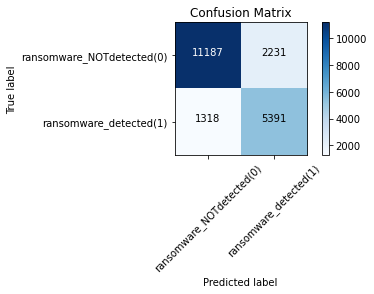

In [ ]:
cm = confusion_matrix(y_true=y_test, y_pred=binary_prediction_array)
cm_plot_labels = ['ransomware_NOTdetected(0)','ransomware_detected(1)']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
y_pred = model.predict(x_test)
#Converting predictions to label
pred = list()
for i in range(len(y_pred)):
    pred.append(np.argmax(y_pred[i]))
#Converting one hot encoded test label to label
test = list()
for i in range(len(y_test)):
    test.append(np.argmax(y_test[i]))

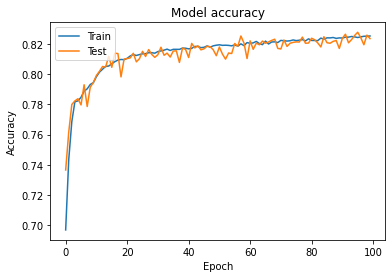

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

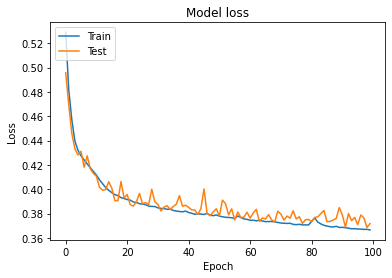

In [ ]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

In [ ]:
### 6. Predicción del dataset sin etiquetar proporcionado